### reference: https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train

In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 10.1MB/s 
     |████████████████████████████████| 952kB 20.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=72011e68decbd68fe8a43002ffe6f5300efb960e66030332c504f59268b507ef
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

rootfolder = '/content/drive/My Drive/dacon - 위성 객체 인식/위성객체폴더'
DIR_TRAIN = os.path.join(rootfolder,'train/images')
#DIR_TEST = os.path.join(rootfolder,'test')
DIR_TEST = os.path.join(rootfolder,'test_sample')

DIR_WEIGHTS = '/content/drive/My Drive/dacon - 위성 객체 인식/위성객체폴더'

WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn.pth'

In [ ]:
test_df = pd.DataFrame()

test_df['image_id'] = os.listdir(DIR_TEST)[:10]
test_df['pred_string'] = '0'

In [ ]:
test_df

,image_id,pred_string
0,OBJ01735_PS3_K3_NIA0104.png,0
1,OBJ00949_PS3_K3_NIA0089.png,0
2,OBJ03542_PS3_K3A_NIA0148.png,0
3,OBJ03518_PS3_K3A_NIA0146.png,0
4,OBJ03511_PS3_K3A_NIA0146.png,0
5,OBJ03472_PS3_K3A_NIA0142.png,0
6,OBJ03411_PS3_K3A_NIA0138.png,0
7,OBJ02587_PS3_K3_NIA0124.png,0
8,OBJ03618_PS3_K3A_NIA0151.png,0
9,OBJ03597_PS3_K3A_NIA0151.png,0


In [ ]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

num_classes = 16  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [ ]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [ ]:
scores = outputs[0]['scores'].data.cpu().numpy()

In [ ]:
boxes = outputs[0]['boxes'].data.cpu().numpy()

In [ ]:
scores>=0.2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
boxes = boxes[scores >= 0.2].astype(np.int32)

In [ ]:
boxes

array([[741, 245, 750, 253],
       [741, 248, 751, 258],
       [932, 845, 941, 858],
       [528, 220, 537, 227],
       [448, 160, 456, 169],
       [739, 240, 748, 249],
       [448, 163, 456, 173],
       [742, 253, 752, 263],
       [208, 236, 218, 243],
       [213, 234, 223, 241],
       [448, 166, 456, 175],
       [  3, 583,  11, 593],
       [  4, 580,  12, 590],
       [744, 216, 751, 221],
       [446, 131, 455, 140],
       [573, 223, 579, 227],
       [  6, 577,  13, 584],
       [600, 214, 607, 221],
       [447, 157, 457, 166],
       [745, 259, 754, 267],
       [943, 186, 953, 193],
       [595, 215, 603, 222]], dtype=int32)

In [ ]:
sample = images[0].permute(1,2,0).cpu().numpy()
boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()

In [ ]:
boxes = boxes[scores >= 0.2].astype(np.int32)

In [ ]:
boxes

array([[741, 245, 750, 253],
       [741, 248, 751, 258],
       [932, 845, 941, 858],
       [528, 220, 537, 227],
       [448, 160, 456, 169],
       [739, 240, 748, 249],
       [448, 163, 456, 173],
       [742, 253, 752, 263],
       [208, 236, 218, 243],
       [213, 234, 223, 241],
       [448, 166, 456, 175],
       [  3, 583,  11, 593],
       [  4, 580,  12, 590],
       [744, 216, 751, 221],
       [446, 131, 455, 140],
       [573, 223, 579, 227],
       [  6, 577,  13, 584],
       [600, 214, 607, 221],
       [447, 157, 457, 166],
       [745, 259, 754, 267],
       [943, 186, 953, 193],
       [595, 215, 603, 222]], dtype=int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


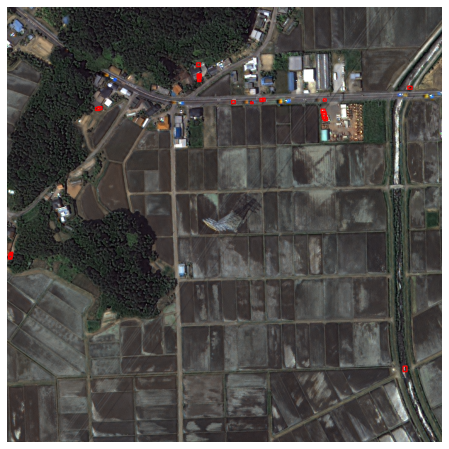

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)